In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.pyplot import figure

rcParams['font.family'] = 'Times New Roman'
rcParams['font.sans-serif'] = ['Times New Roman']


## RQ2 - Figure 5: Best Worst Distribution

In [2]:
# values = {
#     "Random": {"Best": 4, "Worst": 3},
#     "Triphone": {"Best": 5, "Worst": 8},
#     "Phoneme": {"Best": 2, "Worst": 9},
#     "PEP": {"Best": 5, "Worst": 5},
#     "PEP-D": {"Best": 4, "Worst": 7},
#     "SEP": {"Best": 6, "Worst": 3},
#     "WEP": {"Best": 7, "Worst": 0},
#     "WEP-D": {"Best": 4, "Worst": 1},
# }

values = {
    "Random": {"Best": 6, "Worst": 3},
    "Phoneme-Rich": {"Best": 2, "Worst": 12},
    "PEP": {"Best": 5, "Worst": 5},
    "PEP-D": {"Best": 6, "Worst": 10},
    "CrossASR": {"Best": 7, "Worst": 4},
    "Prophet": {"Best": 10, "Worst": 1}
}

df = pd.DataFrame(values)
df = df.T

df


,Best,Worst
Random,6,3
Phoneme-Rich,2,12
PEP,5,5
PEP-D,6,10
CrossASR,7,4
Prophet,10,1


In [3]:
df_prop = df.T.apply(lambda x: x / x.sum(), axis=0).T
df_prop

,Best,Worst
Random,0.666667,0.333333
Phoneme-Rich,0.142857,0.857143
PEP,0.500000,0.500000
PEP-D,0.375000,0.625000
CrossASR,0.636364,0.363636
Prophet,0.909091,0.090909


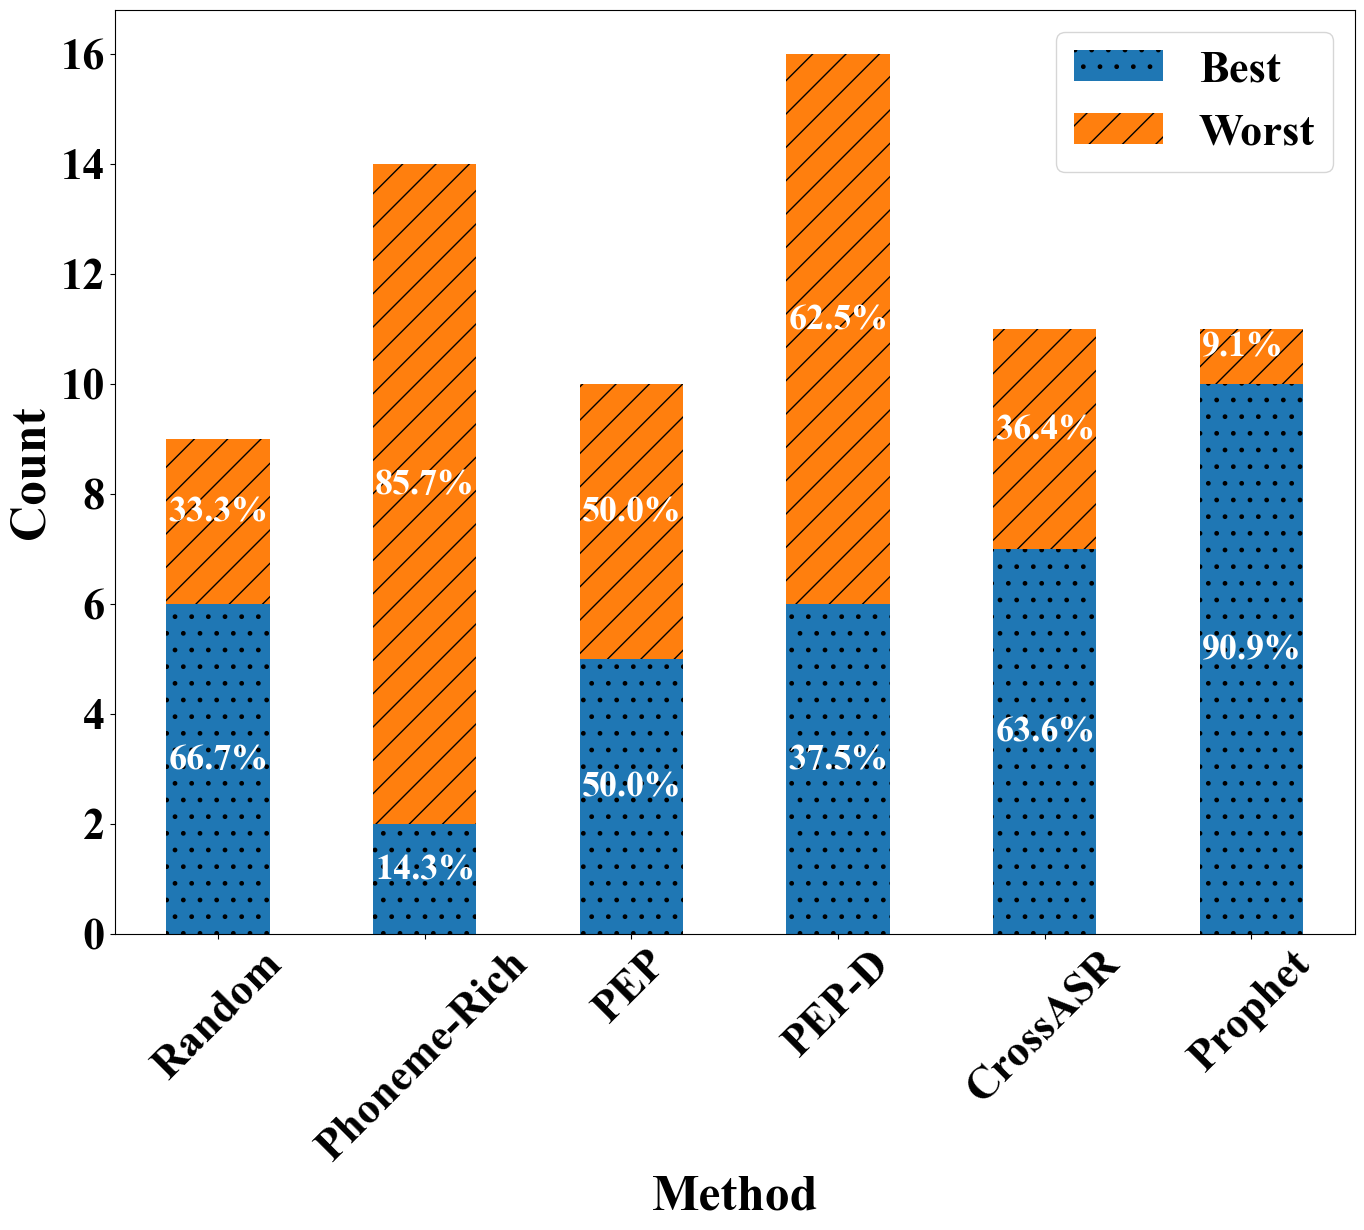

In [4]:
ax = plt.figure(figsize=(16, 12)).add_subplot(111)

df.plot(
    ax=ax,
    kind='bar',
    stacked=True,
    colormap=None,
    figsize=(16, 12)
)
plt.xlabel("Method", size=36, fontweight='bold')
plt.ylabel("Count", size=36, fontweight='bold')

plt.xticks(fontsize=32, fontweight='bold', rotation=45)
plt.yticks(fontsize=32, fontweight='bold')

bars = ax.patches
hatches = ''.join(h*len(df) for h in './*.x/O')

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

plt.legend(prop={'size': 32,'weight': 'bold'})

for n, x in enumerate([*df.index.values]):
    for proportion, y_loc in zip(df_prop.loc[x], df_prop.loc[x].cumsum()):

        plt.text(x=n-0.24,
                 y=((y_loc - proportion) + (proportion / 2)) * df.loc[x].sum(),
                 s=f'{np.round(proportion * 100, 1)}%',
                 color="white",
                 fontsize=26,
                 fontweight="bold")

# plt.grid(b=True, axis='both', linewidth=0.8)

filename = "result/plot/best_worst_distribution.pdf"
plt.savefig(filename, bbox_inches='tight')


### Visualize the number of Significant Correlation

https://www.geeksforgeeks.org/bar-plot-in-matplotlib/

In [5]:
fpath = "result/analyze/1/original_model_performance_correlation_group_by_dataset_and_asr_and_budget.txt"


def read_saved_data(fpath):
    data = {}
    for key in ["asr", "dataset", "budget", "corr_coef", "p_value"]:
        data[key] = []
    with open(fpath, "r") as f:
        lines = f.readlines()
        i = 0
        while i < len(lines):
            line = lines[i].strip()
            if line.startswith("Dataset:"):
                dataset = line.split()[-1]
                i += 1
                line = lines[i].strip()
                asr = line.split()[-1]
                i += 1
                line = lines[i].strip()
                budget = line.split()[-1]
                i += 1
                line = lines[i].strip()
                corr_coeff = float(line.split()[-1])
                i += 1
                line = lines[i].strip()
                p_value = float(line.split()[-1])

                data["asr"].append(asr)
                data["dataset"].append(dataset)
                data["budget"].append(budget)
                data["corr_coef"].append(corr_coeff)
                data["p_value"].append(p_value)
            i += 1

    df = pd.DataFrame(data)

    df["significance"] = df["p_value"].apply(lambda x: True if x < 0.05 else False)
    df["is_positive"] = df["corr_coef"].apply(lambda x: True if x >= 0 else False)
    df["is_negative"] = df["corr_coef"].apply(lambda x: True if x < 0 else False)
    df["guildford_scale"] = df["corr_coef"].apply(lambda x: "low" if abs(x) <= 0.4 else ("moderate" if abs(x) <= 0.7 else "high"))
    return df

df = read_saved_data(fpath)
df


,asr,dataset,budget,corr_coef,p_value,significance,is_positive,is_negative,guildford_scale
0,quartznet,YBAA,100,0.187895,0.414717,False,True,False,low
1,quartznet,YBAA,200,0.399224,0.072997,False,True,False,low
2,quartznet,YBAA,300,0.144173,0.532957,False,True,False,low
3,quartznet,YBAA,400,-0.054993,0.812844,False,False,True,low
4,hubert,YBAA,100,0.508184,0.018666,True,True,False,moderate
...,...,...,...,...,...,...,...,...,...
139,hubert,TLV,400,0.225041,0.326703,False,True,False,low
140,wav2vec-base,TLV,100,-0.113896,0.623016,False,False,True,low
141,wav2vec-base,TLV,200,0.149089,0.518930,False,True,False,low
142,wav2vec-base,TLV,300,0.452328,0.039515,True,True,False,moderate


In [6]:
def get_statistic(df):
    stat = {}
    stat["positive"] = {}
    stat["negative"] = {}

    stat["positive"]["high"] = len(df[df["is_positive"] & (df["significance"] == True) &  (df["guildford_scale"] == "high")])
    stat["positive"]["moderate"] = len(df[df["is_positive"] & (df["significance"] == True) &  (df["guildford_scale"] == "moderate")])
    stat["positive"]["low"] = len(df[df["is_positive"] & (df["significance"] == True) &  (df["guildford_scale"] == "low")])
    stat["positive"]["insignificance"] = len(df[df["is_positive"] & (df["significance"] == False)])

    stat["negative"]["high"] = len(df[df["is_negative"] & (df["significance"] == True) &  (df["guildford_scale"] == "high")])
    stat["negative"]["moderate"] = len(df[df["is_negative"] & (df["significance"] == True) &  (df["guildford_scale"] == "moderate")])
    stat["negative"]["low"] = len(df[df["is_negative"] & (df["significance"] == True) &  (df["guildford_scale"] == "low")])
    stat["negative"]["insignificance"] = len(df[df["is_negative"] & (df["significance"] == False)])

    return stat

stat = get_statistic(df)

In [7]:
metadata = {
    "OMP": "result/analyze/1/original_model_performance_correlation_group_by_dataset_and_asr_and_budget.txt",
    "TR": "result/analyze/3/triphone_rich_correlation_group_by_dataset_and_asr_and_budget.txt",
    "PSF": "result/analyze/4/phoneme_submodular_function_correlation_group_by_dataset_and_asr_and_budget.txt",
}

stats = {}

for key, fpath in metadata.items():
    stats[key] = get_statistic(read_saved_data(fpath))

stats


{'OMP': {'positive': {'high': 1,
   'moderate': 21,
   'low': 0,
   'insignificance': 74},
  'negative': {'high': 0, 'moderate': 1, 'low': 0, 'insignificance': 47}},
 'TR': {'positive': {'high': 0, 'moderate': 7, 'low': 0, 'insignificance': 85},
  'negative': {'high': 0, 'moderate': 3, 'low': 0, 'insignificance': 49}},
 'PSF': {'positive': {'high': 0,
   'moderate': 5,
   'low': 0,
   'insignificance': 48},
  'negative': {'high': 0, 'moderate': 9, 'low': 0, 'insignificance': 82}}}

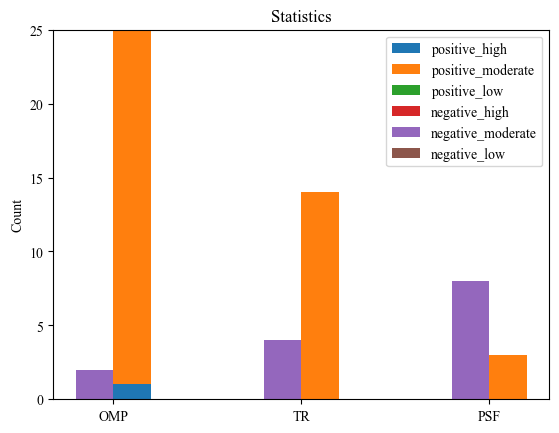

In [8]:
# https://stackoverflow.com/a/68722685

import pandas as pd
import matplotlib.pyplot as plt

df_positive = pd.DataFrame(dict(A=[1, 0, 0], B=[24, 14, 3], C=[0, 0, 0]))
df_negative = pd.DataFrame(dict(A=[0, 0, 0], B=[2, 4, 8], C=[0, 0, 0]))

f, ax = plt.subplots()
ax.bar(df_positive.index, df_positive.A, align='edge', width=0.2)
ax.bar(df_positive.index, df_positive.B, align='edge', width=0.2, bottom=df_positive.A)
ax.bar(df_positive.index, df_positive.C, align='edge', width=0.2, bottom=df_positive.A + df_positive.B)

ax.bar(df_negative.index, df_negative.A, align='edge', width=-0.2)
ax.bar(df_negative.index, df_negative.B, align='edge', width=-0.2, bottom=df_negative.A)
ax.bar(df_negative.index, df_negative.C, align='edge', width=-0.2, bottom=df_negative.A + df_negative.B)

plt.ylabel('Count')
plt.title('Statistics')
plt.xticks(df_positive.index, metadata.keys())

plt.legend(('positive_high', 'positive_moderate',
           'positive_low', 'negative_high', 'negative_moderate', 'negative_low'))
